## Setup

In [1]:
# general setup
%run setup.ipynb
# import popgen
# development setup
%reload_ext autoreload
%autoreload 1
%aimport popgen
%aimport popgen.config
%aimport popgen.analysis
%aimport popgen.util

In [2]:
# setup analysis (see analysis_config.ipynb for configuration)
analysis = popgen.analysis.PopulationAnalysis('../data/analysis')
analysis

<PopulationAnalysis at '../data/analysis'>

In [3]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

## Analysis

In [4]:
chromosomes = ('2R', '2L', '3R', '3L', 'X')
autosomes = chromosomes[:4]

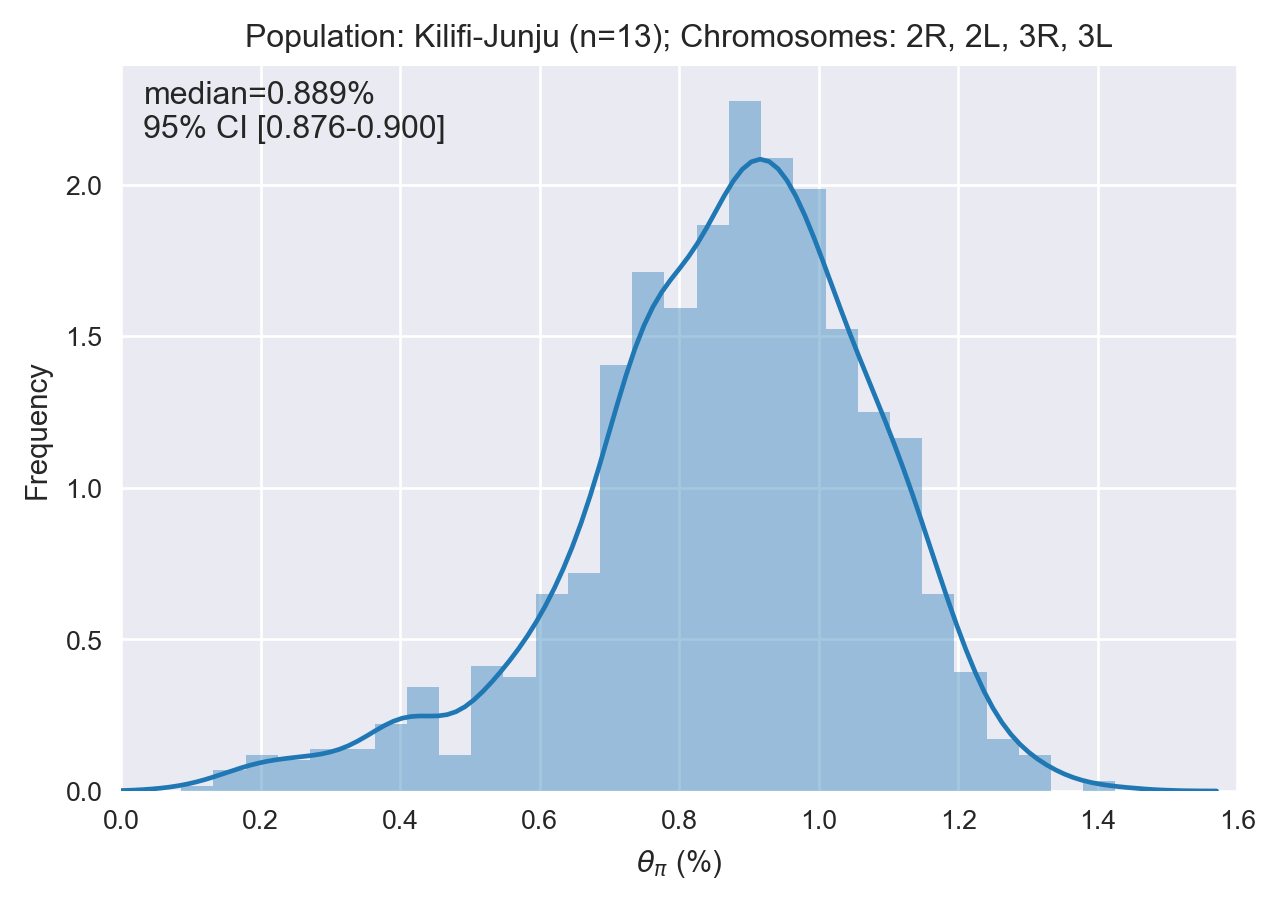

In [5]:
analysis.windowed_diversity_distplot(chrom=autosomes, window_size=100000, pop='junju', xlim=(0, 1.6))

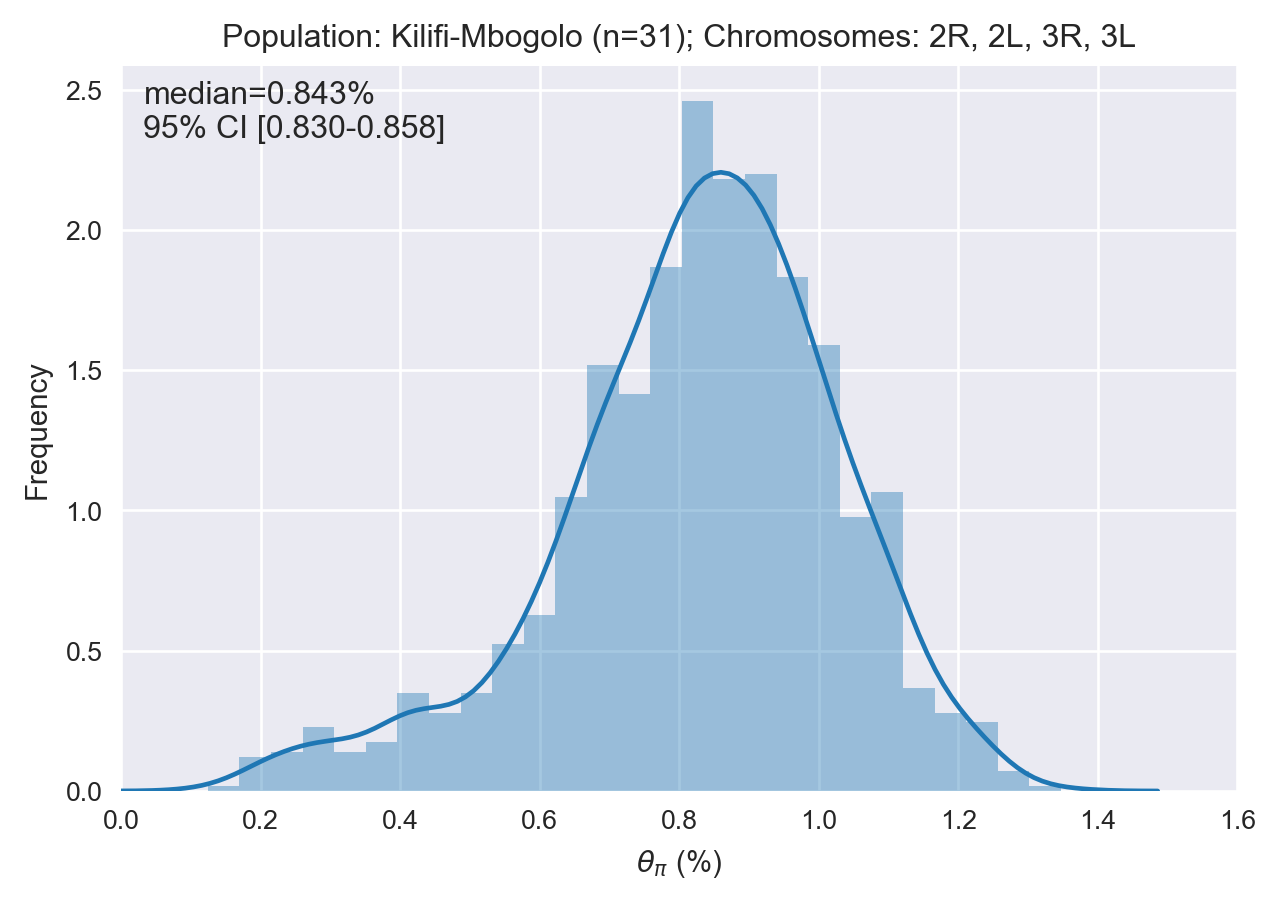

In [6]:
analysis.windowed_diversity_distplot(chrom=autosomes, window_size=100000, pop='mbogolo', xlim=(0, 1.6))

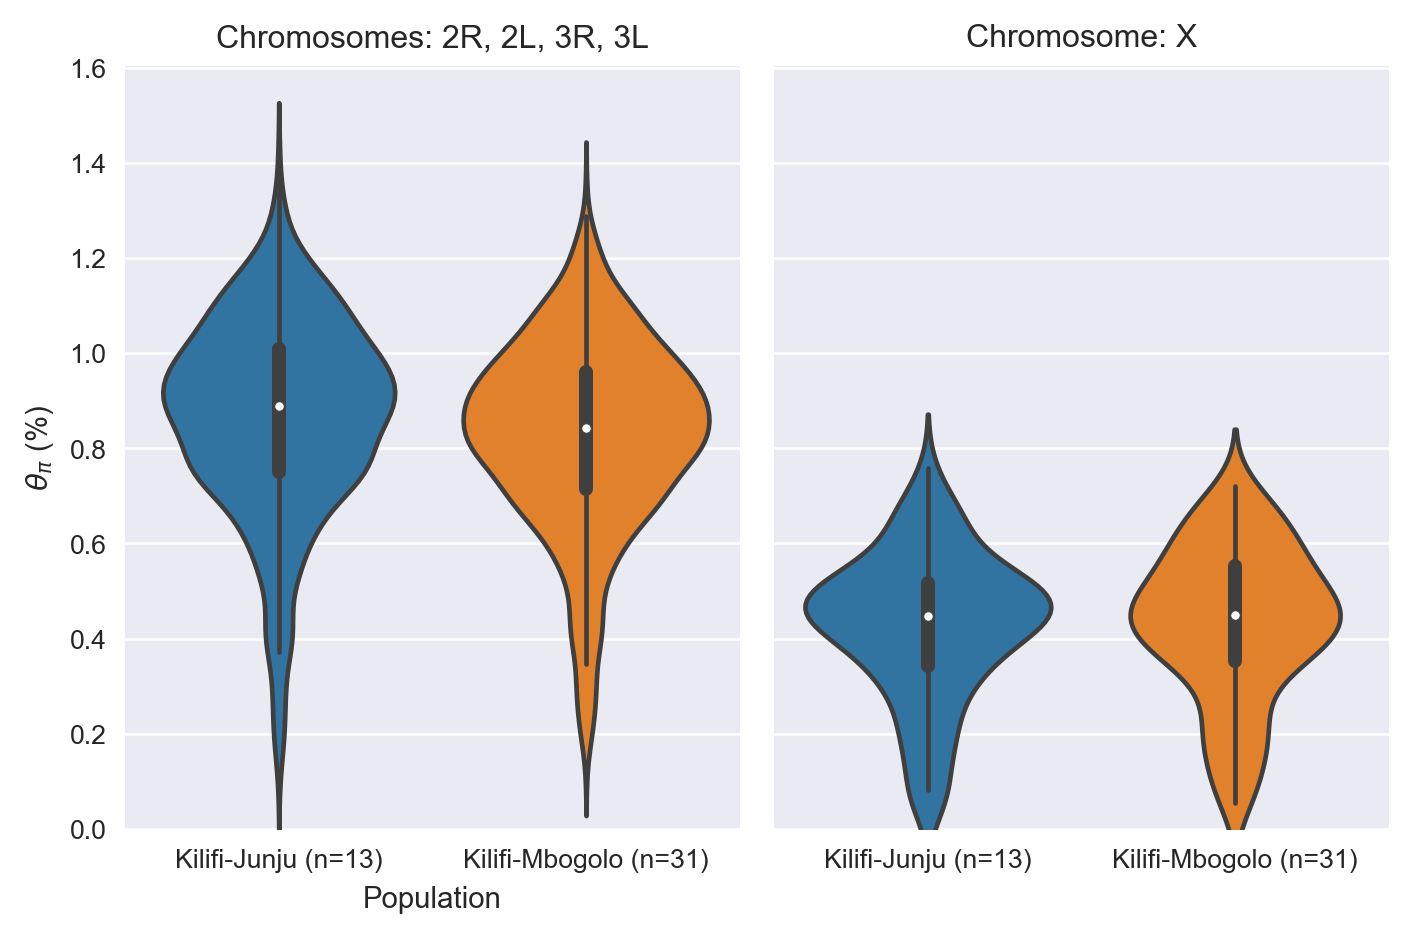

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
analysis.windowed_diversity_violinplot(chrom=autosomes, window_size=100000, pops=['junju', 'mbogolo'], ax=axs[0])
analysis.windowed_diversity_violinplot(chrom='X', window_size=100000, pops=['junju', 'mbogolo'], ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
fig.tight_layout()
fig.savefig('../artwork/pi_comparisons.png', bbox_inches='tight')

In [8]:
analysis.windowed_diversity_compare(chrom=autosomes, pops=['junju', 'mbogolo'], window_size=100000)

Nucleotide diversity; chromosomes 2R, 2L, 3R, 3L
------------------------------------------------
Kilifi-Junju (n=13)   : median=0.889%; 95% CI [0.876-0.900]
Kilifi-Mbogolo (n=31) : median=0.843%; 95% CI [0.829-0.858]
Kilifi-Junju (n=13) versus Kilifi-Mbogolo (n=31) : Wilcoxon signed rank test P=1.32e-35; statistic=238514.0


In [9]:
analysis.windowed_diversity_compare(chrom='X', pops=['junju', 'mbogolo'], window_size=100000)

Nucleotide diversity; Chromosome X
----------------------------------
Kilifi-Junju (n=13)   : median=0.448%; 95% CI [0.429-0.476]
Kilifi-Mbogolo (n=31) : median=0.449%; 95% CI [0.420-0.470]
Kilifi-Junju (n=13) versus Kilifi-Mbogolo (n=31) : Wilcoxon signed rank test P=0.260; statistic=4924.0


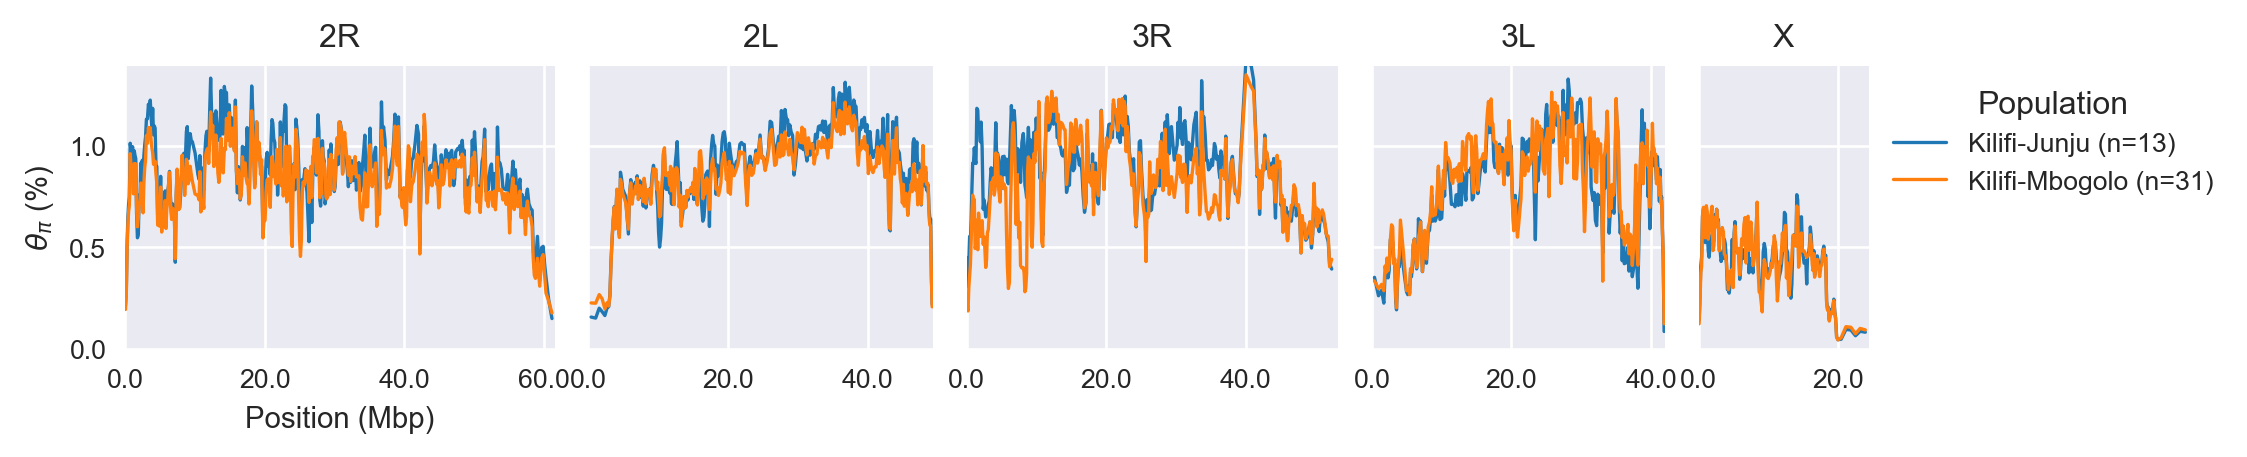

In [13]:
fig = plt.figure(figsize=(8, 2))
analysis.windowed_diversity_genomeplot(chroms=chromosomes, pop='junju', window_size=100000, fig=fig)
analysis.windowed_diversity_genomeplot(chroms=chromosomes, pop='mbogolo', window_size=100000, fig=fig)
fig.savefig('../artwork/pi_genome.png', bbox_inches='tight')

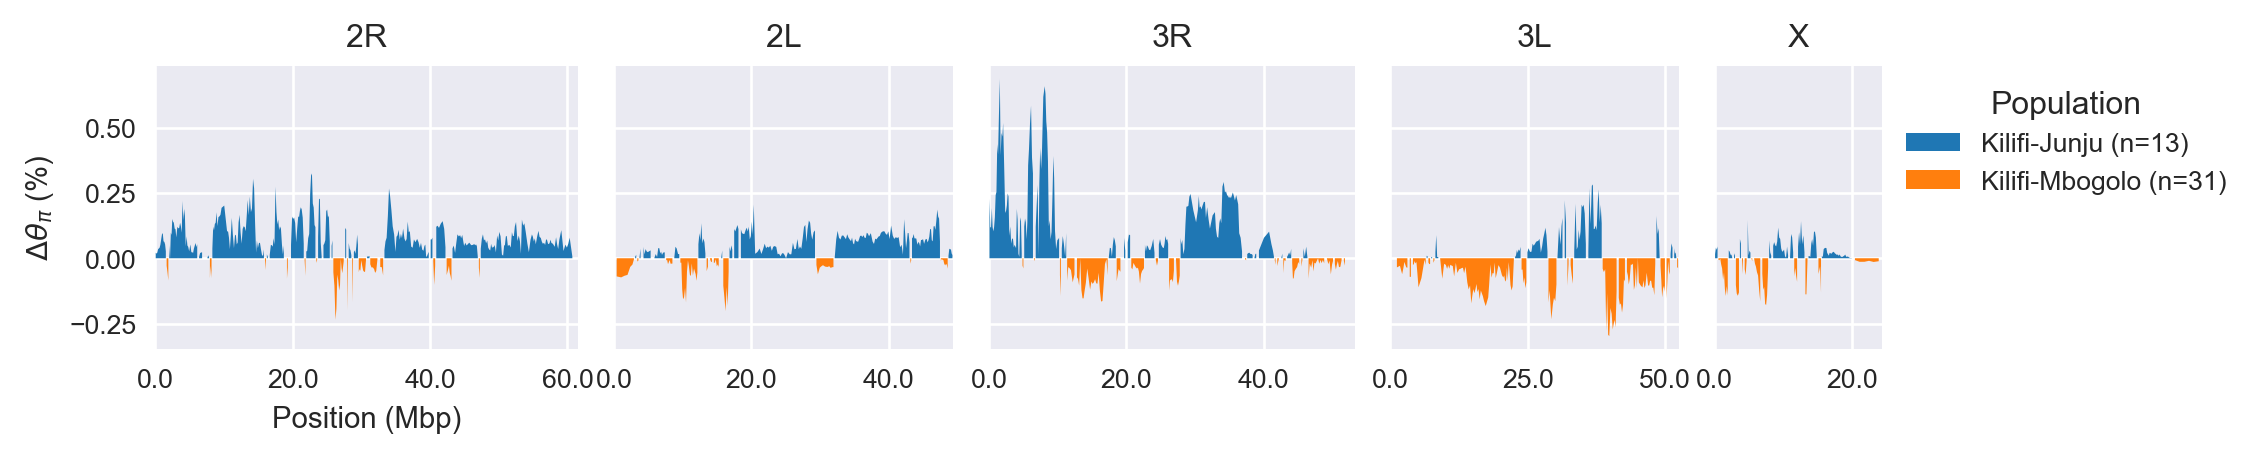

In [11]:
fig = plt.figure(figsize=(8, 2))
analysis.windowed_diversity_delta_genomeplot(chroms=chromosomes, pop1='junju', pop2='mbogolo', window_size=100000, fig=fig)
fig.savefig('../artwork/pi_delta_genome.png', bbox_inches='tight')